# TP Large Scale Kernel Methods

<strong>Introduction</strong>: 

Large scale methode is a way to transform X into special forms with needs, in order to seperate data linearly. Large Scale Kernel Methodes are usually used with SVM methode.


Group members:
- Xi LI
- Benyang SUN
- Di WU

In [0]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file
import time

## Chargement et partitionnement des données

In [0]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = './ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [0]:
from sklearn.svm import SVC, LinearSVC
from time import time

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = SVC(kernel='rbf')
clf.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
accuracy_kernel = clf.score(X_test,y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)

# TODO same for LinearSVC

# timing_linear = 

Fitting SVC rbf on 20000 samples...
done in 4.308s
Predicting with SVC rbf on 40000 samples...
done in 5.127s
classification accuracy: 0.980


In [0]:
print("Fitting LinearSVC on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = LinearSVC(dual=False)
clf.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with LinearSVC on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
accuracy_kernel = clf.score(X_test,y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)

Fitting LinearSVC on 20000 samples...
done in 0.065s
Predicting with LinearSVC on 40000 samples...
done in 0.010s
classification accuracy: 0.917


<strong>Obervation: </strong>
- For Training and Prediction : LinearSVC is much faster than SVC with RBF kernel.
- For Classification Accuracy : SVC with RBF kernel is better than LinearSVC.

<strong>Conclusion: </strong>
- LinearSVC is faster, but SVC with RBF kernel is more accurate.

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [0]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u, s, vt = svds(gram_mat,k=k)
        gram_mat_k = np.dot(u, np.dot(np.diag(s), vt))
    else:
        u, s, vt = svd(gram_mat)
        gram_mat_k = np.dot(u[:,:k], np.dot(np.diag(s[:k]), vt[:k,:]))

    return gram_mat_k


## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [0]:
from numpy.linalg import norm

p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    #print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    rel_error[k] = norm(gram_mat_k - gram_signal, ord='fro') / norm(gram_signal, ord='fro')

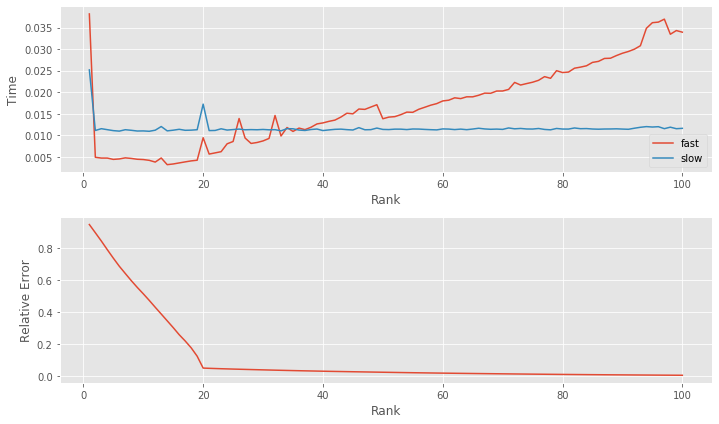

In [0]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

<strong>Observation:</strong>
- The first graph shows the relationship between ranks and time of calculation. We can see that the fast version is faster in the first 20 ranks, then it becomes more and more slower. The time of slow version is constant. At about rank = 35, the slow version becomes faster than fast version.
- The second graph shows the relationship between ranks and relative error. We can see that the relative error decreases very fast from ranks = 0 until ranks = 20. From ranks = 20 to ranks = 100, the relative error decreases about 0.05.

<strong>Conclusion:</strong>
- We can deduce that the best approximation of Gram rank is 20.
- In terms of timing: if ranks is small, the fast version is better; if ranks is huge, then the slow version is a good choice.


## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [0]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    w = rng.normal(0,np.sqrt(2*gamma),(n_features,c))
    b = rng.uniform(0,2*np.pi,(1,c))
    
    X_new_train = np.sqrt(2/c)*np.cos(np.dot(X_train,w)+b)
    X_new_test = np.sqrt(2/c)*np.cos(np.dot(X_test,w)+b)
    
    
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [0]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)

Fitting SVC linear on 20000 samples...
done in 1.610s
Predicting with SVC linear on 40000 samples...
done in 0.025s
classification accuracy: 0.963


<strong>Observation</strong>: 
- In terms of accuracy: Random Kernel Features method has an accuracy equals to 0.963, which is higher than classical linear kernel method which is 0.917, but lower than the RBF kernel method which is 0.98. 
- In terms of time consuming: Random Kernel Features method is slower than classical kernel method, but faster than RBF kernel method.

<strong>Conclusion</strong>: 
- Random Kernel Features method is a compromise between linear kernel method and RBF kernel method regarding to accuracy and time consuming.


## Question 6

On implémente la méthode de Nystrom.

In [0]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    # TODO
    u, s, vt = svd(W, full_matrices=False)
    u = u[:,:k]
    s = s[:k]
   
    M = np.dot(u,np.diag(1./np.sqrt(s)))
    
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    
    X_new_train = np.dot(C_train,M)
    X_new_test = np.dot(C_test,M)
    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [0]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 1.273s
Predicting with SVC linear on 40000 samples...
done in 0.024s
classification accuracy: 0.976


<strong>Observation</strong>: 
- In terms of accuracy: Nyström method has an accuracy of 0.976, which is even better than Random Kernel Features method which is 0.963 and of course linear kernel method which is 0.917. However, RBF kernel method still hold the best accuracy with 0.98.
- In terms of time consuming: Nyström method fitted and predicted in 1.3s, which is faster than Random Kernel Features method which is 1.6s and RBF kernel method. However, Nyström method is still slower than linear kernel method.

<strong>Conclusion</strong>: 
- Nyström method is better than Random Kernel Features method regarding to accuracy and time consuming. 
- Nyström is still a compromise between linear kernel method and RBF kernel method.

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [0]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
timing_linear = np.zeros(n_ranks)
timing_rbf = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)
accuracy_linear = np.zeros(n_ranks)
accuracy_rbf = np.zeros(n_ranks)


print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    
    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    # put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
    r_train, r_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    n_train, n_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    clf = LinearSVC(dual=False)
   
    #Random
    t0=time()
    clf.fit(r_train, y_train)
    accuracy_rkf[i] = clf.score(r_test, y_test)
    timing_rkf[i] = time()-t0
    
    #Nystrom
    t0=time()
    clf.fit(n_train, y_train)    
    accuracy_nystrom[i] = clf.score(n_test, y_test)
    timing_nystrom[i] = time()-t0

    #Linear classic kernel
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(X_train, y_train)
    accuracy_linear[i] = clf.score(X_test, y_test)
    timing_linear[i] = time() - t0
    
    #RBF classic kernel
    t0 = time()
    clf = SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    accuracy_rbf[i] = clf.score(X_test, y_test)
    timing_rbf[i] = time() - t0

Training SVMs for various values of c...


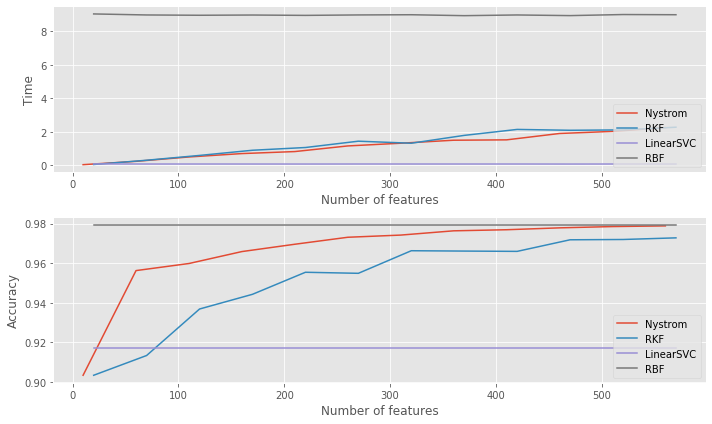

In [0]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_rbf * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_rbf * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

<strong>Observation:</strong>
- The first graph represent the relatin between time and ranks for the 4 methods. We can see that the RBF takes more time than other three. Nyström takes slightly less time than RKF. And LinearSVC takes the least time.
- The second graph represents the relationship between accuracy and ranks. We can see that the RBF method has the best accuracy. With increasing of ranks, Nyström and RKF surpass the accuracy of LinearSVC at about rank = 20 and rank = 75 respectively, and are approaching to the accuracy of RBF method. It is interesting to see that while Nyström surpass the LinearSVC, the rank value equals to the Gram approximation rank value.

<strong>Total conclusion of TP:</strong>
- Generally speaking, the <strong>linearSVC method</strong> is the fastest. But since it's much less tunable and is basically just a linear interpolation, the accuracy is not always the best.
- In our case, we can see that the <strong>Radial Basis Function method (RBF)</strong> has the best accuracy, but it's more time consuming. It's expensive for big scale dataset.
- The <strong>Random Kernel Features method</strong> and <strong>Nyström method</strong> are compromised between performance and cost. In our case, <strong>Nyström method</strong> is better than <strong>Random Kernel Features method</strong> regarding to accuracy and time consuming. In order to increase their accuracy, we could increase the rank value, without sacrificing a lot of calculation time.